# Colab Setup

In [ ]:
! pip install -r requirements.txt

Importing Data from Kaggle

In [11]:
from google.colab import files
files.upload()

! pip install -q kaggle
! mkdir ~/.kaggle # making new directory
! cp kaggle.json ~/.kaggle/ # copying kaggle json file to the created directory
! chmod 600 ~/.kaggle/kaggle.json # changing the permissions
! kaggle datasets download -d sgpjesus/bank-account-fraud-dataset-neurips-2022 # downloading the dataset
! mkdir data # making new directory on colab session to unzip the dataset in it
! unzip -q bank-account-fraud-dataset-neurips-2022.zip -d data # unzipping the downloaded data

# Loading the classes

In [20]:
from data_cleaning import *
from modeling import *
from preprocessing import *

# Splitting the data

Here we'll split data into training and testing same as the provided baseline notebook based on month column

In [4]:
def split_data(df,criteria='random'):
    X = df.drop(['fraud_bool'], axis=1)
    y = df['fraud_bool']
    if criteria=='paper':

        # Train test split by 'month', month 0-5 are train, 6-7 are test data as proposed in the paper
        X_train = X[X['month']<6]
        X_test = X[X['month']>=6]
        y_train = y[X['month']<6]
        y_test = y[X['month']>=6]


    elif criteria=='random':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    elif criteria=='stratify':

        X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

    X_train.drop('month', axis=1, inplace=True)
    X_test.drop('month', axis=1, inplace=True)
    return X_train, X_test, y_train, y_test

# Reading the data

In [5]:
df=data_cleaning('/content/data/Base.csv').get_data()

In [ ]:
#df.head()

In [6]:
# split the data
X_train, X_test, y_train, y_test=split_data(df,criteria= 'paper')

# Getting the groups:

In [7]:
train_groups=(X_train["customer_age"] > 50).map({True: ">50", False: "<=50"})
test_groups=(X_test["customer_age"] > 50).map({True: ">50", False: "<=50"})

# Start the preprocessing

In [8]:
data = preprocessing(X_train, y_train)


# Scaling numerical features:

Use "Standard Scaler" for numerical features same as baseline notebook

In [9]:
scalers = {}
for column in X_train.select_dtypes(include=['int','float']):
    m,scaler=data.scale_data('standard',column)
    scalers[column] = scaler

Apply transform on test data

In [10]:
# apply the same scaling on the testset
for column in X_test.select_dtypes(include=['int','float']):
    X_test[column] = scalers[column].transform(X_test[[column]])

# Encode the categorical features

Using One Hot Encoder

In [11]:
encoders = {}
for column in X_train.select_dtypes(include=['category','object']):
    _, encoder = data.encode_categorical_features(column , encoding_type= 'one-hot')
    encoders[column] = encoder

Transform the test data

In [12]:
# apply the encoding on the testset
for column in X_test.select_dtypes(include=['object','category']).columns:
    ohe=encoders[column]
    encoded_col = pd.DataFrame(ohe.transform(X_test[column].values.reshape(-1, 1)).toarray(),index=X_test.index)
    encoded_col.columns = [column + '_' + str(val) for val in ohe.categories_[0]]
    X_test = pd.concat([X_test, encoded_col], axis=1)
    X_test.drop(columns=column, inplace=True,axis=1)

In [ ]:
#data.concat_data()

In [13]:
# arrange the column names according to the concat data
X_test=X_test[data.concat_data().columns]

In [14]:
X_train,y_train=data.get_data()

# Modeling : Training and Evaluation

In [15]:
experiment=modeling(X_train,X_test,y_train,y_test,train_groups,test_groups)

In [16]:
param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0],
    'penalty': ['l2', 'l1'],
    'class_weight': ['balanced']
}

# Create a logistic regression object
lr = LogisticRegression()

Fitting 1 folds for each of 8 candidates, totalling 8 fits
Best hyperparameters: {'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.01}
Best estimator: LogisticRegression(C=0.01, class_weight='balanced')
Best score: 0.8775634142788866
AUC: 0.8797011199394454
TPR:  49.65% 
FPR:  5.0% 
Threshold:  0.76
Predictive Equality:  88.42999999999999%


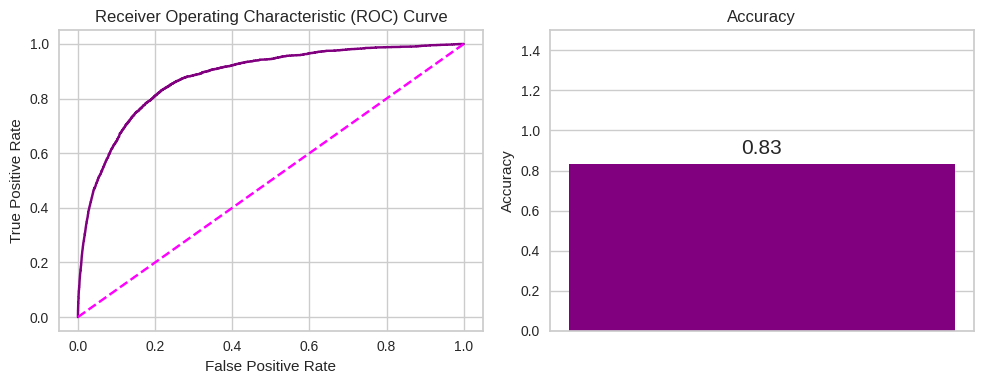

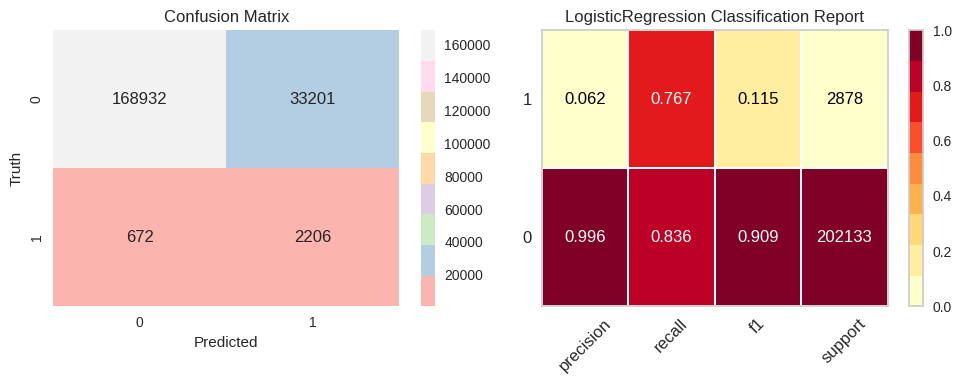

CPU times: user 35.3 s, sys: 7.91 s, total: 43.2 s
Wall time: 1min 48s


In [17]:
%%time
experiment.train(lr,param_grid=param_grid,search_type='random')

In [18]:
# Save the best model
saved_model_path = experiment.save_model('logistic_model.pkl')
print("Model saved at:", saved_model_path)

Model saved at: logistic_model.pkl


In [ ]:
#!pip install pipreqs
#!pipreqs .